In [41]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (replace with your actual data loading)
# Assuming the data is in a CSV file named 'landslide_data.csv'
data = pd.read_csv('Global_Landslide_Catalog_Export.csv')

# ==============================================
# Data Preprocessing
# ==============================================

# Convert date to datetime and extract temporal features
data['event_date'] = pd.to_datetime(data['event_date'])
data['month'] = data['event_date'].dt.month
data['season'] = (data['month'] % 12 + 3) // 3  # 1=winter, 2=spring, etc.

# Create binary target variable (1 if fatality occurred, 0 otherwise)
data['fatality_occurred'] = (data['fatality_count'] > 0).astype(int)

# Feature engineering
data['heavy_rain'] = data['landslide_trigger'].isin(['rain', 'downpour']).astype(int)
data['mining_area'] = (data['landslide_setting'] == 'mine').astype(int)

# ==============================================
# Feature Selection
# ==============================================

# Selected features based on our discussion
features = [
    'latitude', 'longitude',          # Geospatial
    'month', 'season',                # Temporal
    'heavy_rain',                     # Weather
    'mining_area',                    # Land use
    'landslide_size',                 # Historical patterns
    'admin_division_population'       # Human impact factor
]

target = 'fatality_occurred'  # Binary classification

# Prepare the data
X = data[features]
y = data[target]

# ==============================================
# Data Splitting
# ==============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# ==============================================
# Preprocessing Pipeline
# ==============================================

# Numeric features (standard scaling)
numeric_features = ['latitude', 'longitude', 'month', 
                   'admin_division_population']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical features (one-hot encoding)
categorical_features = ['landslide_size', 'season']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1719
           1       0.48      0.78      0.60       488

    accuracy                           0.77      2207
   macro avg       0.70      0.77      0.72      2207
weighted avg       0.83      0.77      0.78      2207


Confusion Matrix:
[[1308  411]
 [ 107  381]]

Accuracy: 0.765292251925691


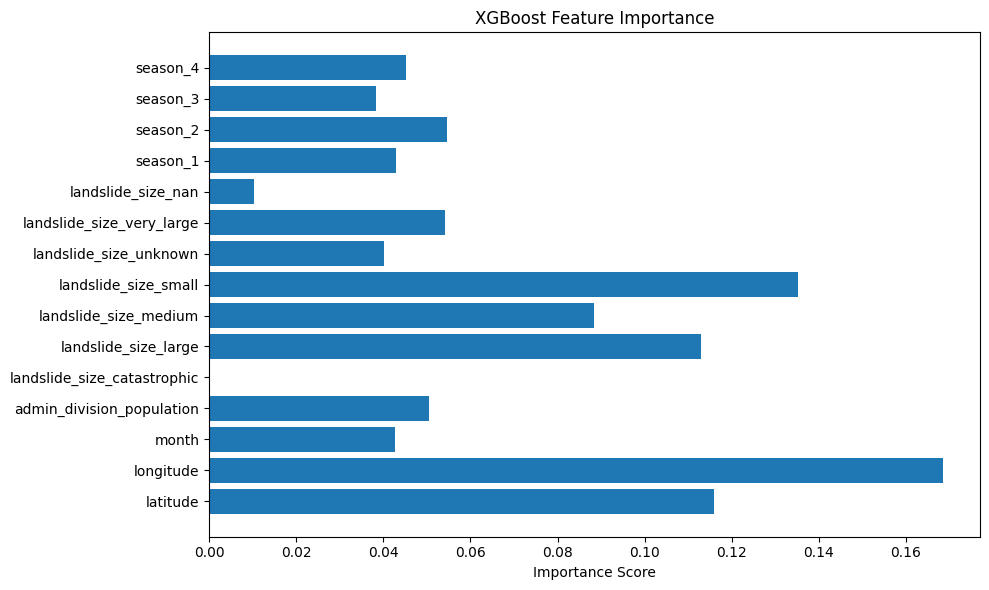

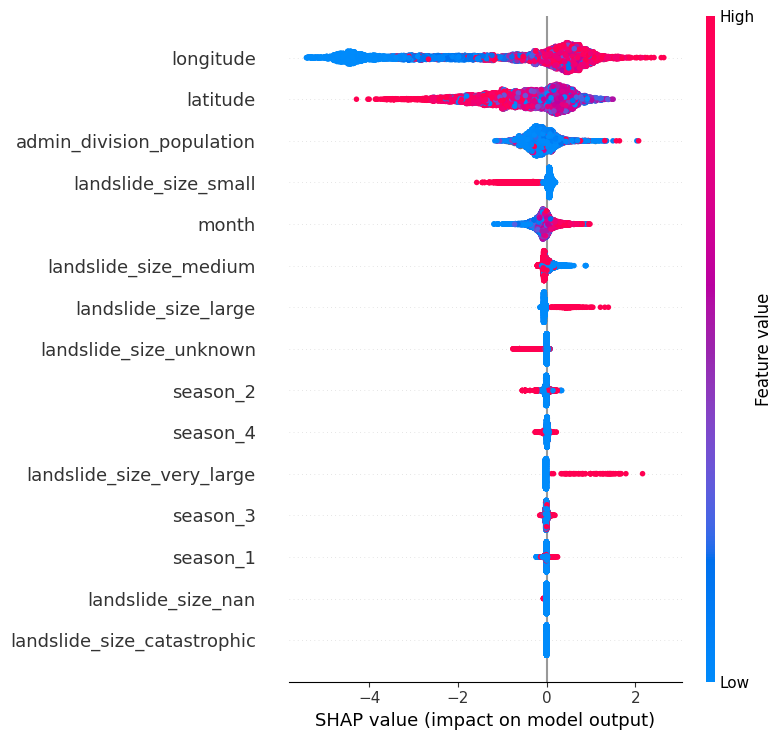


Example Prediction:
{'location': {'country': 'India', 'admin_division': 'Mumbai', 'latitude': 19.054999, 'longitude': 72.8692035, 'zip_code': 'N/A'}, 'month': 1, 'rainfall_mm': 69.6, 'prediction': 'High risk', 'probability_high_risk': 0.5610038042068481, 'probability_low_risk': 0.43899619579315186}


In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd
import requests



# ==============================================
# XGBoost Model with Hyperparameter Tuning
# ==============================================

from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        objective='binary:logistic',
        enable_categorical=False  # Let OneHotEncoder handle it
    ))
])



param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.9],
    'classifier__colsample_bytree': [0.9],
    'classifier__gamma': [0, 0.1]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='f1',  # Good for imbalanced data
    n_jobs=-1,     # Use all available cores
    verbose=1
)



grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# ==============================================
# Model Evaluation
# ==============================================

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

# ==============================================
# Feature Importance Analysis
# ==============================================

# Get feature names after preprocessing
preprocessor.fit(X)
feature_names = numeric_features + \
    list(best_model.named_steps['preprocessor']\
        .named_transformers_['cat']\
        .named_steps['onehot']\
        .get_feature_names_out(categorical_features).tolist())

# Plot feature importance
xgb_feature_importances = best_model.named_steps['classifier'].feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_feature_importances)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# SHAP values for model interpretation
X_processed = best_model.named_steps['preprocessor'].transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_processed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_processed, feature_names=feature_names)
# plt.title('SHAP Value Summary Plot')
# plt.tight_layout()
# plt.show()

# ==============================================
# Prediction Function for New Data
# ==============================================


def get_simple_precipitation(lat, lon, date):
    """
    Get precipitation from NOAA using lat/lon by reverse lookup to the nearest station
    """
    headers = {'token': 'OTTkgxkCdpKiEubbNzCpCcsbmisFDIFL'}
    
    # Find station near lat/lon — requires station lookup if ZIP isn't known
    # Here we'll simplify: Use a placeholder or cached locationid for now
    # Proper version needs to find closest station using NOAA metadata
    
    location_id = f"FIPS:37021"  # Replace with actual location ID if available
    
    url = f"http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCNDMS&locationid={location_id}&startdate={date}&enddate={date}"
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        precip_mm = None
        for record in data.get('results', []):
            if record['datatype'] == 'TPCP':
                precip_mm = record['value'] / 10  # tenths of mm to mm
                break
                
        return precip_mm
        
    except Exception as e:
        print(f"Precipitation API Error: {e}")
        return None


def predict_landslide_risk(country, admin_division, month, date):
    """
    Predict landslide risk using real precipitation data.
    """
    # Geocoding
    geolocator = Nominatim(user_agent="landslide_pred")
    location = geolocator.geocode(f"{admin_division}, {country}")
    
    if not location:
        return {"error": "Location not found"}
    
    # Get real rainfall data
    precip_mm = get_simple_precipitation(location.latitude, location.longitude, date)
    
    if precip_mm is None:
        return {"error": "Rainfall data unavailable for the given location/date"}
    
    # Prepare input
    input_data = pd.DataFrame({
        'latitude': [location.latitude],
        'longitude': [location.longitude],
        'month': [month],
        'season': [(month % 12 + 3) // 3],
        'rainfall_mm': [precip_mm],  # New actual rainfall input
        'mining_area': [0],  # Default
        'landslide_size': ['medium'],  # Default
        'admin_division_population': [
            data[data['admin_division_name'] == admin_division]['admin_division_population'].mean() or 100000
        ]
    })
    
    # Predict
    proba = best_model.predict_proba(input_data)[0]
    prediction = best_model.predict(input_data)[0]
    
    # Extract ZIP code if available
    zipcode = location.raw.get('address', {}).get('postcode', 'N/A')

    return {
        'location': {
            'country': country,
            'admin_division': admin_division,
            'latitude': location.latitude,
            'longitude': location.longitude,
            'zip_code': zipcode
        },
        'month': month,
        'rainfall_mm': precip_mm,
        'prediction': 'High risk' if prediction == 1 else 'Low risk',
        'probability_high_risk': float(proba[1]),
        'probability_low_risk': float(proba[0])
    }



# Example usage
print("\nExample Prediction:")
print(predict_landslide_risk("India", "Mumbai", 1, "2000-02-01"))  # January in Oregon

In [69]:
print("\nExample Prediction:")
print(predict_landslide_risk("India", "New Delhi", 1, "2002-07-01"))  # January in Oregon


Example Prediction:
{'location': {'country': 'India', 'admin_division': 'New Delhi', 'latitude': 28.6430858, 'longitude': 77.2192671, 'zip_code': 'N/A'}, 'month': 1, 'rainfall_mm': 81.1, 'prediction': 'High risk', 'probability_high_risk': 0.625010073184967, 'probability_low_risk': 0.37498992681503296}


In [58]:
import requests
url = "http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCNDMS&locationid=ZIP:97001&startdate=2000-01-31&enddate=2000-02-02"
# replace 'myToken' with the actual token, below
headers = {'token': 'OTTkgxkCdpKiEubbNzCpCcsbmisFDIFL'}
response = requests.get(url, headers = headers)
response = response.json()
print(response)

{'metadata': {'resultset': {'offset': 1, 'count': 18, 'limit': 25}}, 'results': [{'date': '2000-02-01T00:00:00', 'datatype': 'CLDD', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DP01', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 10}, {'date': '2000-02-01T00:00:00', 'datatype': 'DP05', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DP10', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DT00', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DT32', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 26}, {'date': '2000-02-01T00:00:00', 'datatype': 'DT90', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DX32', 'station': 'GHCND:USC00350197', 'attrib

In [ ]:
test_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets"
test = requests.get(test_url, headers=headers)
print(test.status_code)  

200
